<a href="https://colab.research.google.com/github/FadeZx/DT-467_ChessMoveTracking/blob/PieceMapping/2_2024_DT_467_ChessMove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset preparation / Preprocessing

In [28]:
!pip install easyocr

In [29]:
!pip install ultralytics

In [30]:
!pip install python-chess

In [4]:
#import dataset1 no oriented
!pip install -U gdown
!gdown --folder https://drive.google.com/drive/folders/1-NaFCqOomOCt5EpskeDT7ez1_DZ_8k3m

Retrieving folder contents
Processing file 1sw65JD2BTd6b24ZpiMPrdlT8ckvBI1hq frame0.jpg
Processing file 1U1DJyDGWuZTt6NWBym1LsdVNK2yIwYkX frame55.jpg
Processing file 1fPd0Lz1UfnW9_upQgWLJ88GTQgB-mPZE frame56.jpg
Processing file 1kGfo6dLN1r7jxE1I9gkHV6yg4zkc5UtW frame57.jpg
Processing file 1xfroP4wMUfdZQmhCnuMHlStbhnxgfY-t frame58.jpg
Processing file 1tvoxfNZ2GMn8AXzukujHpGgRf7MnVTcO frame59.jpg
Processing file 1dSX1jhIAd2Qzhn2H1Vg_EeQsdZPZKTVh frame65.jpg
Processing file 1YUHENekfVEOntvmrjN3YVw78W5YpIGoQ frame66.jpg
Processing file 1U4_aK_ElkDd5jLTmnL8ErH0AjTzmB0zH frame70.jpg
Processing file 1sVsDBEOa3P-bUaL3fLpQxiVjM7cFB4oW frame75.jpg
Processing file 1oaQ2XhaxxuQIN21uQd89L7o5PTHA9C_v frame101.jpg
Processing file 1dgHlb1EYu1hEqm_axz1ODmwqIlCSPZrT frame155.jpg
Processing file 15jYU9ZE6YIAI4acgKym5tmzadMoPE93U frame159.jpg
Processing file 1g3JN_NMHdPKmwrME2q9ff6PIrM5Q0f85 frame173.jpg
Processing file 182W7crKEvSJXevr0Jye3eLZCRknwvM22 frame183.jpg
Processing file 1hUuj4SuLqMOyzrrFAggJtS

In [5]:
#import dataset2
!wget https://drive.google.com/uc?id=1PVeMgv5z_Ua3T33htKAFX27jkkOPHTM_ -O frame_0.jpg
!wget https://drive.google.com/uc?id=1vE7q6qMD_xz8dAvpcEYHL1zC1CspNwPa -O frame_25.jpg
!wget https://drive.google.com/uc?id=1METUm9TQIcKrt-T-1IUDBV_AABLlKct0 -O frame_98.jpg
!wget https://drive.google.com/uc?id=1AnbrrLArLNQMsFsaLytmqi7L_YQ7tiSV -O frame_160.jpg
!wget https://drive.google.com/uc?id=18RpEPCsn4FUu4qOX3ZHPcJL2MMAPj9vk -O frame_212.jpg
!wget https://drive.google.com/uc?id=19RXLuPMF11k3_0ExXxtC69o0yY4uQF4y -O frame_386.jpg
!wget https://drive.google.com/uc?id=11QnEx8AlLdcIMJZPeCY_Gb8YzB4i_rrs -O frame_471.jpg
!wget https://drive.google.com/uc?id=1asMzKguloR7uNA6kB5JpFki2SaFL8f7K -O frame_935.jpg
!wget https://drive.google.com/uc?id=1Js08IbU-jfzT7q960kIOWXHV4YcSgK1w -O frame_1149.jpg
!wget https://drive.google.com/uc?id=1jV00hYmoqeOW8cJgvp-LdJYJgfstMONm -O frame_1183.jpg

--2025-04-28 19:31:37--  https://drive.google.com/uc?id=1PVeMgv5z_Ua3T33htKAFX27jkkOPHTM_
Resolving drive.google.com (drive.google.com)... 64.233.189.138, 64.233.189.101, 64.233.189.113, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1PVeMgv5z_Ua3T33htKAFX27jkkOPHTM_ [following]
--2025-04-28 19:31:37--  https://drive.usercontent.google.com/download?id=1PVeMgv5z_Ua3T33htKAFX27jkkOPHTM_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.157.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198855 (194K) [image/jpeg]
Saving to: ‘frame_0.jpg’

frame_0.jpg         100%[===================>] 194.19K  --.-KB/s    in 0.002s  

2025-04-28 19:31:40 (99.2 MB/s) - ‘frame_0.jpg’

In [71]:
def order_points(pts):
    # pts is a list of 4 (x, y) tuples
    rect = np.zeros((4, 2), dtype="float32")

    # top-left has the smallest sum, bottom-right the largest
    s = np.sum(pts, axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    # top-right has smallest difference, bottom-left the largest
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left

    return rect

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("dataset1_nolabel/frame0.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Set the internal number of corners (for 8x8 board → 7x7 internal corners)
pattern_size = (7, 7)

# Try to find the corners
found, corners = cv2.findChessboardCorners(gray, pattern_size)

# Visualize result
if found:
    img_drawn = cv2.drawChessboardCorners(img.copy(), pattern_size, corners, found)
    plt.imshow(cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB))
    plt.title("Detected Chessboard Corners")
    plt.axis("off")
    plt.show()
else:
    print("Chessboard corners not found.")

Chessboard corners not found.


# Board Detection

In [73]:
import easyocr
from ultralytics import YOLO

Import Chess Corner Dataset

In [9]:
# Correct file_id only
file_id = "1pbFb6THRwvpl0pYI7CjHww6L8lNx-ZOJ"

# Correct usage
!gdown {file_id} --fuzzy -O chessboard_detection.zip

# Then unzip
!unzip chessboard_detection.zip -d chessboard_data

print("Unzipped successfully!")

Downloading...
From (original): https://drive.google.com/uc?id=1pbFb6THRwvpl0pYI7CjHww6L8lNx-ZOJ
From (redirected): https://drive.google.com/uc?id=1pbFb6THRwvpl0pYI7CjHww6L8lNx-ZOJ&confirm=t&uuid=579ec304-8a18-4c0c-b73b-51d64804cd7d
To: /content/chessboard_detection.zip
 14% 302M/2.16G [00:03<00:20, 89.8MB/s]Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gdown/__main__.py", line 172, in main
    download(
  File "/usr/local/lib/python3.11/dist-packages/gdown/download.py", line 368, in download
    for chunk in res.iter_content(chunk_size=CHUNK_SIZE):
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 820, in generate
    yield from self.raw.stream(chunk_size, decode_content=True)
  File "/usr/local/lib/python3.11/dist-packages/urllib3/response.py", line 1066, in stream
    data = self.read(amt=amt, decode_content=decode_content)
       

Training

In [ ]:
model = YOLO('yolov8n.pt')
model.train(
  data='/content/chessboard_data/data.yaml',
  epochs=6,
  imgsz=640,
  batch=16,
  fraction=0.5,
  name='chessboard_detector'
)

Import Trained Model

In [74]:
import gdown
file_id = '1vrz9paUBsMejIr6Sd_iddztwzYxRDs5x'
output = 'best.pt'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1vrz9paUBsMejIr6Sd_iddztwzYxRDs5x
To: /content/best.pt
100%|██████████| 6.25M/6.25M [00:00<00:00, 35.2MB/s]


'best.pt'

Detect Board Labels and Correct Orientation

In [75]:
def detect_board_labels(img, reader, conf_thresh=0.4):
    """
    Detect letters/numbers (a–h, 1–8) using EasyOCR.

    Parameters:
    - img: input BGR image (OpenCV)
    - reader: EasyOCR Reader object
    - conf_thresh: minimum confidence to keep text

    Returns:
    - filtered_labels: list of tuples (label_text, bbox)
    - img_annotated: image with drawn labels for visualization
    """
    results = reader.readtext(img)
    filtered_labels = []

    img_annotated = img.copy()

    for (bbox, text, conf) in results:
        text = text.strip().lower()
        if conf >= conf_thresh and text in ['a','b','c','d','e','f','g','h','1','2','3','4','5','6','7','8']:
            filtered_labels.append((text, bbox))

            # Draw the label and box
            (top_left, top_right, bottom_right, bottom_left) = bbox
            top_left = tuple(map(int, top_left))
            bottom_right = tuple(map(int, bottom_right))

            cv2.rectangle(img_annotated, top_left, bottom_right, (0, 255, 0), 2)
            cv2.putText(img_annotated, text.upper(), top_left, cv2.FONT_HERSHEY_SIMPLEX,
                        0.8, (255, 0, 0), 2)

    return filtered_labels, img_annotated

In [4]:
def find_correct_orientation(img, reader):
    rotations = [0, 90, 180, 270]
    best_rotation = 0
    max_label_confidence = -1

    for angle in rotations:
        if angle == 0:
            rotated = img.copy()
        elif angle == 90:
            rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            rotated = cv2.rotate(img, cv2.ROTATE_180)
        elif angle == 270:
            rotated = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

        results = reader.readtext(rotated)
        img_h = rotated.shape[0]

        for (bbox, text, conf) in results:
            text = text.strip().lower()
            if any(c in text for c in ['1', 'a', '8', 'h']) and conf > 0.4:
                avg_y = np.mean([pt[1] for pt in bbox])
                if avg_y > img_h * 0.6:
                    if conf > max_label_confidence:
                        max_label_confidence = conf
                        best_rotation = angle

    return best_rotation


In [5]:
def set_orientation(img,angle):
    if angle == 90:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        return cv2.rotate(img, cv2.ROTATE_180)
    elif angle == 270:
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        return img

Square Detection

In [6]:
def class_id_to_name(class_id):
  class_names = {
    0: "Empty Square",
    1: "White Pawn",
    2: "White Knight",
    3: "White Bishop",
    4: "White Rook",
    5: "White Queen",
    6: "White King",
    7: "Black Pawn",
    8: "Black Knight",
    9: "Black Bishop",
    10: "Black Rook",
    11: "Black Queen",
    12: "Black King",
  }
  return class_names.get(class_id, "Unknown")

In [7]:
# Helper: predict missing corner
def predict_missing_corner(pts):
    # Assume pts = 3 points
    A, B, C = pts

    # Find the missing D
    # If AB is one side, D = C + (A - B)
    D = C + (A - B)
    predicted_pts = np.vstack([pts, D])
    return predicted_pts

In [83]:
# Warp the chessboard
def warp_chessboard(img, corners, output_size=640, extend_px=0):
    src_pts = corners
    dst_pts = np.array([
        [extend_px, extend_px],
        [output_size, extend_px],
        [output_size, output_size],
        [extend_px, output_size]
    ], dtype=np.float32)
    # dst_pts = np.array([
    #     [0, extend_px],
    #     [output_size, extend_px],
    #     [output_size, output_size],
    #     [0, output_size]
    # ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (output_size + extend_px, output_size + extend_px))
    return warped

In [10]:
# Create mapping from (row,col) to board label
def square_label(row, col):
    file = chr(ord('h') - col)  # a,b,c,d,e,f,g,h
    rank = 1 + row  # 8,7,6...1
    return f"{file}{rank}"

In [11]:
def detect_corners(img_corrected):
  # Load trained model
  model = YOLO('best.pt')

  # Already corrected image
  # img_corrected = find_correct_orientation(img, reader)

  # Last good corners backup
  last_good_corners = None

  # Run YOLO prediction
  results = model.predict(source=img_corrected, imgsz=640, line_width=1, conf=0.25, save_txt=False, save=False)

  # Extract detected corners
  all_corners = []
  for r in results:
      for box in r.boxes.xyxy:  # boxes: (x1, y1, x2, y2)
          x1, y1, x2, y2 = box.tolist()
          cx = (x1 + x2) / 2
          cy = (y1 + y2) / 2
          all_corners.append([cx, cy])
  all_corners = np.array(all_corners, dtype=np.float32)

  print("Detected corners:", all_corners.shape)

  return all_corners

In [12]:
def corner_smart_fallback(img_corrected, all_corners):
  # Smart fallback
  if len(all_corners) == 4:
      print("4 corners detected")
      ordered_corners = order_points(all_corners)
      last_good_corners = ordered_corners
  elif len(all_corners) == 3:
      print("Only 3 corners detected, predicting missing one...")
      predicted_corners = predict_missing_corner(all_corners)
      ordered_corners = order_points(predicted_corners)
      last_good_corners = ordered_corners
  elif last_good_corners is not None:
      print("Using last good corners!")
      ordered_corners = last_good_corners
  else:
      raise Exception("Cannot detect enough corners and no backup available.")

  img_corners = img_corrected.copy()

  return img_corners, ordered_corners

In [13]:
def draw_detected_corners(img_corners, ordered_corners):
  # Draw detected corner points
  for (x, y) in ordered_corners:
      cv2.circle(img_corners, (int(x), int(y)), 10, (0, 255, 0), -1)  # Green dots

  # Draw big contour (the board rectangle)
  pts = ordered_corners.reshape((-1, 1, 2)).astype(np.int32)
  cv2.polylines(img_corners, [pts], isClosed=True, color=(255, 0, 0), thickness=3)  # Blue rectangle

  # Draw internal grid lines (8x8 squares)
  # interpolate points between the corners
  for i in range(1, 8):
      # Horizontal lines (left to right between top and bottom edges)
      pt1 = ordered_corners[0] + i / 8 * (ordered_corners[1] - ordered_corners[0])
      pt2 = ordered_corners[3] + i / 8 * (ordered_corners[2] - ordered_corners[3])
      cv2.line(img_corners, tuple(pt1.astype(int)), tuple(pt2.astype(int)), (0, 255, 255), 2)

      # Vertical lines (top to bottom between left and right edges)
      pt1 = ordered_corners[0] + i / 8 * (ordered_corners[3] - ordered_corners[0])
      pt2 = ordered_corners[1] + i / 8 * (ordered_corners[2] - ordered_corners[1])
      cv2.line(img_corners, tuple(pt1.astype(int)), tuple(pt2.astype(int)), (0, 255, 255), 2)

  plt.figure(figsize=(10,10))
  plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
  plt.title("Corners + Board Outline + Segmentation Lines")
  plt.axis('off')
  plt.show()

In [14]:
def split_square(warped_board, ordered_corners):
  # Split the warped board into 8x8 cells
  cell_size = warped_board.shape[0] // 8
  buffer_size = int(2 * cell_size / 3)

  squares = []
  labels = []  # <-- add a label list
  cells_info = []

  # Interpolate points along top and bottom edges
  top_row = np.linspace(ordered_corners[0], ordered_corners[1], 9)
  bottom_row = np.linspace(ordered_corners[3], ordered_corners[2], 9)

  h, w, _ = warped_board.shape

  for row in range(8):
      for col in range(8):
          tl = top_row[col] + (row / 8) * (bottom_row[col] - top_row[col])
          tr = top_row[col+1] + (row / 8) * (bottom_row[col+1] - top_row[col+1])
          br = top_row[col+1] + ((row+1) / 8) * (bottom_row[col+1] - top_row[col+1])
          bl = top_row[col] + ((row+1) / 8) * (bottom_row[col] - top_row[col])

          x_start = col * cell_size
          x_end = (col + 1) * cell_size

          y_start = row * cell_size - buffer_size
          y_end = (row + 1) * cell_size

          # Clamp to valid bounds
          y_start = max(y_start, 0)
          y_end = min(y_end, h)
          x_start = max(x_start, 0)
          x_end = min(x_end, w)

          square = warped_board[y_start:y_end, x_start:x_end]
          squares.append(((row, col), square))
          labels.append(square_label(row, col))  # save label
          corners = np.array([tl, tr, br, bl], dtype=np.float32)

          cells_info.append({
              "label": labels[-1],
              "row": row,
              "col": col,
              "corners": corners,
              "status": "Empty"   # Default as empty initially
          })

  fig, axes = plt.subplots(8, 8, figsize=(12, 16))

  for (row, col), square_img in squares:
      ax = axes[row, col]
      ax.imshow(cv2.cvtColor(square_img, cv2.COLOR_BGR2RGB))
      ax.set_title(square_label(row, col), fontsize=8)
      ax.axis('off')

  plt.tight_layout()
  plt.show()

  print("Board cell info with corners and status:")
  for cell in cells_info:
      print(f"Cell {cell['label']} - Status: {cell['status']}")
      for idx, corner in enumerate(cell['corners']):
          print(f"  Corner {idx}: {corner}")
      print("")

  return cells_info

# Piece Detection

Import Trained Model

In [15]:
file_id = '1RSFK-RY6PcNitl6oTRDVKZWF6C7294kV'
output = 'chesspieces_best.pt'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1RSFK-RY6PcNitl6oTRDVKZWF6C7294kV
To: /content/chesspieces_best.pt
100%|██████████| 5.48M/5.48M [00:00<00:00, 51.3MB/s]


'chesspieces_best.pt'

In [16]:
file_id = '1OPm9SE2EK1A5KPGdjZSAWiQfSMT3eWxe'
output = 'chesspieces_model3.pt'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1OPm9SE2EK1A5KPGdjZSAWiQfSMT3eWxe
To: /content/chesspieces_model3.pt
100%|██████████| 5.48M/5.48M [00:00<00:00, 47.1MB/s]


'chesspieces_model3.pt'

# Piece mapping

In [94]:
def extract_board(img_corrected):
  # Load trained model
  model = YOLO('best.pt')

  # Last good corners backup
  last_good_corners = None

  # Run YOLO prediction
  results = model.predict(source=img_corrected, imgsz=640, line_width=1, conf=0.25, save_txt=False, save=False)

  # Extract detected corners
  all_corners = []
  for r in results:
    for box in r.boxes.xyxy:  # boxes: (x1, y1, x2, y2)
      x1, y1, x2, y2 = box.tolist()
      cx = (x1 + x2) / 2
      cy = (y1 + y2) / 2
      all_corners.append([cx, cy])

  all_corners = np.array(all_corners, dtype=np.float32)

  # Smart fallback
  if len(all_corners) == 4:
      # 4 corners detected
      ordered_corners = order_points(all_corners)
      last_good_corners = ordered_corners
  elif len(all_corners) == 3:
      # 3 corners detected: predict the missing one
      predicted_corners = predict_missing_corner(all_corners)
      ordered_corners = order_points(predicted_corners)
      last_good_corners = ordered_corners
  elif last_good_corners is not None:
      # Use last good corners
      ordered_corners = last_good_corners
  else:
      raise Exception("Cannot detect enough corners and no backup available.")

  img_corners = img_corrected.copy()

  # Draw detected corner points
  for (x, y) in ordered_corners:
    cv2.circle(img_corners, (int(x), int(y)), 10, (0, 255, 0), -1)  # Green dots

  # Draw big contour (the board rectangle)
  pts = ordered_corners.reshape((-1, 1, 2)).astype(np.int32)
  cv2.polylines(img_corners, [pts], isClosed=True, color=(255, 0, 0), thickness=3)  # Blue rectangle

  # Draw internal grid lines (8x8 squares)
  # interpolate points between the corners
  for i in range(1, 8):
      # Horizontal lines (left to right between top and bottom edges)
      pt1 = ordered_corners[0] + i / 8 * (ordered_corners[1] - ordered_corners[0])
      pt2 = ordered_corners[3] + i / 8 * (ordered_corners[2] - ordered_corners[3])
      cv2.line(img_corners, tuple(pt1.astype(int)), tuple(pt2.astype(int)), (0, 255, 255), 2)

      # Vertical lines (top to bottom between left and right edges)
      pt1 = ordered_corners[0] + i / 8 * (ordered_corners[3] - ordered_corners[0])
      pt2 = ordered_corners[1] + i / 8 * (ordered_corners[2] - ordered_corners[1])
      cv2.line(img_corners, tuple(pt1.astype(int)), tuple(pt2.astype(int)), (0, 255, 255), 2)

  # Warp the chessboard
  output_size = 640
  header_size = 40
  warped_board = warp_chessboard(img_corrected, ordered_corners, output_size + header_size, header_size)
  warped_board_corners = warp_chessboard(img_corners, ordered_corners, output_size + header_size, header_size)

  # Enhance Image
  lap_filter = np.array([[0,1,0],[1,-4,1],[0,1,0]], np.int16)
  dst_im = cv2.filter2D(warped_board,-1,lap_filter)
  brightness_increase = 30
  enhanced_img = cv2.subtract(warped_board, np.clip(dst_im, 0, 255).astype(np.uint8))
  enhanced_img = cv2.add(enhanced_img, brightness_increase)
  enhanced_img_corner = cv2.subtract(warped_board_corners, np.clip(dst_im, 0, 255).astype(np.uint8))
  enhanced_img_corner = cv2.add(enhanced_img_corner, brightness_increase)

  # Set up the board grid
  w, h, _ = warped_board.shape

  x_min = header_size
  y_min = header_size
  x_max = w - header_size
  y_max = h - header_size

  square_width = (x_max - x_min) / 8
  square_height = (y_max - y_min) / 8

  # Initialize 8x8 array empty board
  board = [[None for _ in range(8)] for _ in range(8)]

  # Detect Piece
  piece_model = YOLO('/content/chesspieces_model3.pt')
  results = piece_model.predict(enhanced_img, imgsz=640, conf=0.25, iou=0.5)

  for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    conf = float(box.conf[0])
    cls_id = int(box.cls[0])
    label = results[0].names[cls_id]

    label_text = f"{label} {conf:.2f}"

    # Draw bounding box
    cv2.rectangle(enhanced_img_corner, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Calculate the center point of the box
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)

    # Draw label text inside the box, centered
    font_scale = 0.5   # Smaller text
    thickness = 1
    text_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    text_w, text_h = text_size

    # Adjust so that text is centered
    text_x = center_x - text_w // 2
    text_y = center_y + text_h // 2

    cv2.putText(enhanced_img_corner, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), thickness, cv2.LINE_AA)

    # Get anchor point of the chess piece
    anchor_x = (x1 + x2) / 2
    anchor_y = y2

    # Find which square the center point falls into
    col = int((anchor_x - x_min) / square_width)
    row = int((anchor_y - y_min) / square_height)

    # Clamp to [0, 7]
    col = min(max(col, 0), 7)
    row = min(max(row, 0), 7)

    # Place the piece label on the board

    board[row][col] = label

  # # Show correct orientation image
  # plt.figure(figsize=(8, 8))
  # plt.imshow(cv2.cvtColor(img_corrected, cv2.COLOR_BGR2RGB))
  # plt.title("Corrected Orientation Image")
  # plt.axis("off")
  # plt.show()

  # # SHow board with lines
  # plt.figure(figsize=(8, 8))
  # plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
  # plt.title("Board Outline + Segmentation Lines")
  # plt.axis('off')
  # plt.show()

  # # Show warped board
  # plt.figure(figsize=(8, 8))
  # plt.imshow(cv2.cvtColor(warped_board_corners, cv2.COLOR_BGR2RGB))
  # plt.title('Warped Chessboard')
  # plt.axis('off')
  # plt.show()

  # # Show result board
  # plt.figure(figsize=(8, 8))
  # plt.imshow(cv2.cvtColor(enhanced_img_corner, cv2.COLOR_BGR2RGB))
  # plt.title('Piece Detected Chessboard')
  # plt.axis('off')
  # plt.show()

  fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # 2 rows, 2 columns

  # List of images and titles
  images = [
      (img_corrected, "Corrected Orientation Image"),
      (img_corners, "Board Outline + Segmentation Lines"),
      (warped_board_corners, "Warped Chessboard"),
      (enhanced_img_corner, "Piece Detected Chessboard")
  ]

  # Flatten axes for easy iteration
  axes = axes.flatten()

  for ax, (img, title) in zip(axes, images):
      ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      ax.set_title(title, fontsize=12)
      ax.axis('off')

  plt.tight_layout()
  plt.show()

  return board

In [96]:
piece_to_unicode = {
    'white-pawn': '♙',
    'white-knight': '♘',
    'white-bishop': '♗',
    'white-rook': '♖',
    'white-queen': '♕',
    'white-king': '♔',
    'black-pawn': '♟',
    'black-knight': '♞',
    'black-bishop': '♝',
    'black-rook': '♜',
    'black-queen': '♛',
    'black-king': '♚',
}

# Visualization

In [77]:
import chess
import chess.svg
import chess.pgn

In [78]:
chessboard = chess.Board()
first_mover_color = None
first_move_made = False

piece_to_fen = {
    'white-pawn': 'P',
    'white-knight': 'N',
    'white-bishop': 'B',
    'white-rook': 'R',
    'white-queen': 'Q',
    'white-king': 'K',
    'black-pawn': 'p',
    'black-knight': 'n',
    'black-bishop': 'b',
    'black-rook': 'r',
    'black-queen': 'q',
    'black-king': 'k',
}

def create_fen_from_array(board_array):
    fen_rows = []
    for row in board_array:
        fen_row = ''
        empty_count = 0
        for cell in row:
            if cell is None:
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += piece_to_fen[cell]
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)
    fen_position = '/'.join(fen_rows)

    return fen_position

def coords_to_square(row, col):
    # Chessboard indexing: row 0 = rank 8, col 0 = file 'a'
    file = chr(ord('a') + col)
    rank = str(8 - row)
    return file + rank

def find_move(before, after):
    move_from = None
    move_to = None
    moved_piece = None

    for i in range(len(before)):
        for j in range(len(before[i])):
            if before[i][j] != after[i][j]:
                if before[i][j] != 'None' and after[i][j] == 'None':
                    move_from = (i, j)
                    moved_piece = before[i][j]
                elif before[i][j] == 'None' and after[i][j] != 'None':
                    move_to = (i, j)

    return move_from, move_to, moved_piece


def handle_move(before, after):
    global chessboard, first_mover_color, first_move_made

    move_from, move_to, moved_piece = find_move(before, after)

    #no move detected, exit
    if move_from is None or move_to is None:
        return

    from_square = coords_to_square(*move_from)
    to_square = coords_to_square(*move_to)
    uci_move = from_square + to_square

    # Setup first move if needed
    if not first_move_made:
        if moved_piece.startswith('white'):
            first_mover_color = 'white'
        elif moved_piece.startswith('black'):
            first_mover_color = 'black'
        else:
            raise ValueError("Unknown piece color!")

        # Create and set the FEN based on the first before_board
        fen = create_fen_from_array(before)
        chessboard.set_board_fen(fen)

        # Adjust turn if needed
        if first_mover_color == 'white':
            chessboard.turn = chess.WHITE
        else:
            chessboard.turn = chess.BLACK

        first_move_made = True
        print(f"First mover detected: {first_mover_color}")
        print(f"FEN set: {fen}")

    print(f"Move detected: {uci_move}")

    move = chess.Move.from_uci(uci_move)
    if move in chessboard.legal_moves:
        chessboard.push(move)
        return True
    else:
        print("Illegal move detected:", move)
        return False

# Main

In [110]:
# This function will be used for marking, do not change function name, input parameters and return parameters of this function
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, SVG

def chess_move(video_name):
  # Input : video filename (.mp4)
  # Output : Chess moves for each video
  moves = ""

  # Create a VideoCapture object
  cap = cv2.VideoCapture(video_name)

  # Check if the video opened successfully
  if not cap.isOpened():
      print("Error opening video file")

  # Read and display frames until the video ends or 'q' is pressed
  fps = cap.get(cv2.CAP_PROP_FPS)
  frame_count = 0

  # EasyOCR Reader and Video Angle
  reader = easyocr.Reader(['en'], gpu=True)
  angle = 0

  # Initialize 8x8 array empty previous_board
  previous_board = [[None for _ in range(8)] for _ in range(8)]

  # Write your code here to extract the move from the image
  while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
      break

    if ret and frame_count == 0:
      chessboard.reset()
      first_move_made = False
      print("Reset Board")
      #angle = find_correct_orientation(frame, reader)

    if ret and frame_count % int(fps * 15) == 0:
      plt.figure(figsize=(8, 8))
      plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)); plt.title('Original Image'); plt.axis('off')
      plt.show()

      board = extract_board(set_orientation(frame, angle))

      for row in board:
        print(" | ".join(f"{(str(piece_to_fen[item]) if item is not None else '-'): <1}" for item in row))

      fen_string = create_fen_from_array(board)
      chessboard.set_board_fen(fen_string)

      # if frame_count == 0:
      #   fen_string = create_fen_from_array(board)
      #   chessboard.set_board_fen(fen_string)
      # else:
      #   handle_move(previous_board, board)

      display(SVG(chess.svg.board(board=chessboard, size=640)))
      previous_board = board

    frame_count += 1

  # Release the video capture object and close display windows
  cap.release()

  # Generate PGN
  game = chess.pgn.Game()
  node = game

  # Replay moves from the board
  for move in chessboard.move_stack:
      node = node.add_variation(move)

  # Print the PGN
  print(game)
  moves = str(game)

  return moves

# Marking

In [23]:
!pip install editdistance
!pip install opencv-python

In [24]:
!wget https://drive.google.com/uc?id=1a96Ei0hwfMvYUyUK-d0ZxvK6m6uSoAuR -O chess_solution_final_seen.csv

--2025-04-28 19:41:48--  https://drive.google.com/uc?id=1a96Ei0hwfMvYUyUK-d0ZxvK6m6uSoAuR
Resolving drive.google.com (drive.google.com)... 64.233.189.102, 64.233.189.139, 64.233.189.101, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1a96Ei0hwfMvYUyUK-d0ZxvK6m6uSoAuR [following]
--2025-04-28 19:41:48--  https://drive.usercontent.google.com/download?id=1a96Ei0hwfMvYUyUK-d0ZxvK6m6uSoAuR
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.157.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 963 [application/octet-stream]
Saving to: ‘chess_solution_final_seen.csv’

chess_solution_fina 100%[===================>]     963  --.-KB/s    in 0s      

2025-04-28 19:41:51 (41.9

## Download .mp4 file

In [25]:
import subprocess

def download_file(url, filename=None):
    """
    Downloads a file from the specified URL using wget.

    Parameters:
        url (str): The URL of the file to download.
        output_directory (str, optional): The directory to save the downloaded file.
    """
    # Construct the wget command
    cmd = ['wget', url]
    if filename:
        cmd.extend(['-O', filename])

    try:
        # Execute the wget command
        print(cmd)
        subprocess.run(cmd, check=True)
        print(f"Downloaded {url} successfully.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")

In [54]:
# Load videos (or you can upload videos here manually)
f = open('chess_solution_final_seen.csv','r')

for line in f:
  video_name, moves_sol, p,link = line.split(',')
  idx = link.find('/d/')
  idx2 = link.find('/',idx+3)
  print(link[idx+3:idx2])
  url = 'https://drive.google.com/uc?id=' + link[idx+3:idx2]
  download_file(url, video_name)

nk
['wget', 'https://drive.google.com/uc?id=nk', '-O', 'row_id']
An error occurred: Command '['wget', 'https://drive.google.com/uc?id=nk', '-O', 'row_id']' returned non-zero exit status 8.
182pRqfn8ooNudYhsndYWgyBNi7rAV659
['wget', 'https://drive.google.com/uc?id=182pRqfn8ooNudYhsndYWgyBNi7rAV659', '-O', '2_Move_rotate_student.mp4']


KeyboardInterrupt: 

## Scoring your output

In [ ]:
# Read videos
import editdistance

f = open('chess_solution_final_seen.csv','r')
score = 0
n = 0
for line in f:
  video_name, moves_sol, p,link = line.split(',')
  moves = chess_move(video_name)
  s = 1 - editdistance.eval(moves,moves_sol)  / max(len(moves),len(moves_sol))
  score += s
  print(f"your result: ",moves)
  print(f"solution   : ",moves_sol )
  print(f"The edit distance between your results and solution is {s}.")
  n += 1
f.close()
if n != 0:
  print("-----------------------")
  print("Total score :",score/n)
  print("-----------------------")

Error opening video file
your result:  
solution   :  output
The edit distance between your results and solution is 0.0.
your result:  
solution   :  1. Qh4+ 2. g3
The edit distance between your results and solution is 0.0.
your result:  
solution   :  1. Qh4+ 2. g3
The edit distance between your results and solution is 0.0.
Error opening video file
your result:  
solution   :  1. f4 2. Ng6 fxg3 3. Nxh8
The edit distance between your results and solution is 0.0.
Error opening video file
your result:  
solution   :  1. Bxb5 2. Rxb5 b6 3. c4 Ne7 4. Rb2
The edit distance between your results and solution is 0.0.
Error opening video file
your result:  
solution   :  1. Qe6 Kd8 2. Qf7 c6 3. Qf2 cxd5 4. Qxa7 Rc8 5. Rxb4 Nc6 6. Qb6+
The edit distance between your results and solution is 0.0.
Error opening video file
your result:  
solution   :  1. f4 d5 2. Nf3 Bf5 3. Nc3 Nc6 4. Nxd5 e6 5. Ne3 Qh4+ 6. Nxh4 Nh6 7. Nxf5 Nxf5 8. Nxf5 exf5 9. d4 Nxd4 10. Qxd4 Rd8 11. Qe5+ Kd7 12. Qxf5+ Kc6 13. Qxf

2_move_student.mp4
Reset Board


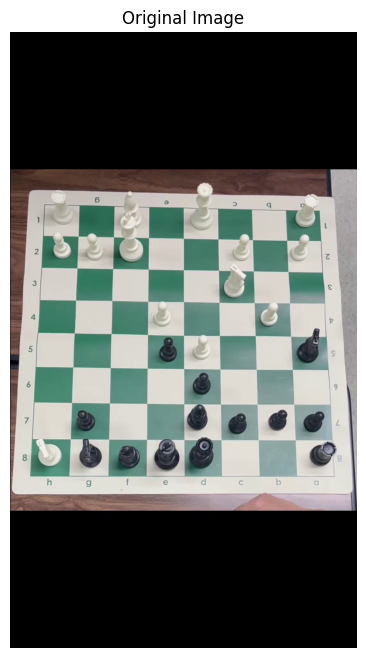


0: 640x384 4 chess-table-cornerss, 139.5ms
Speed: 4.5ms preprocess, 139.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 6 black-pawns, 1 black-queen, 1 black-rook, 2 white-bishops, 2 white-kings, 2 white-knights, 7 white-pawns, 2 white-queens, 2 white-rooks, 184.7ms
Speed: 6.1ms preprocess, 184.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


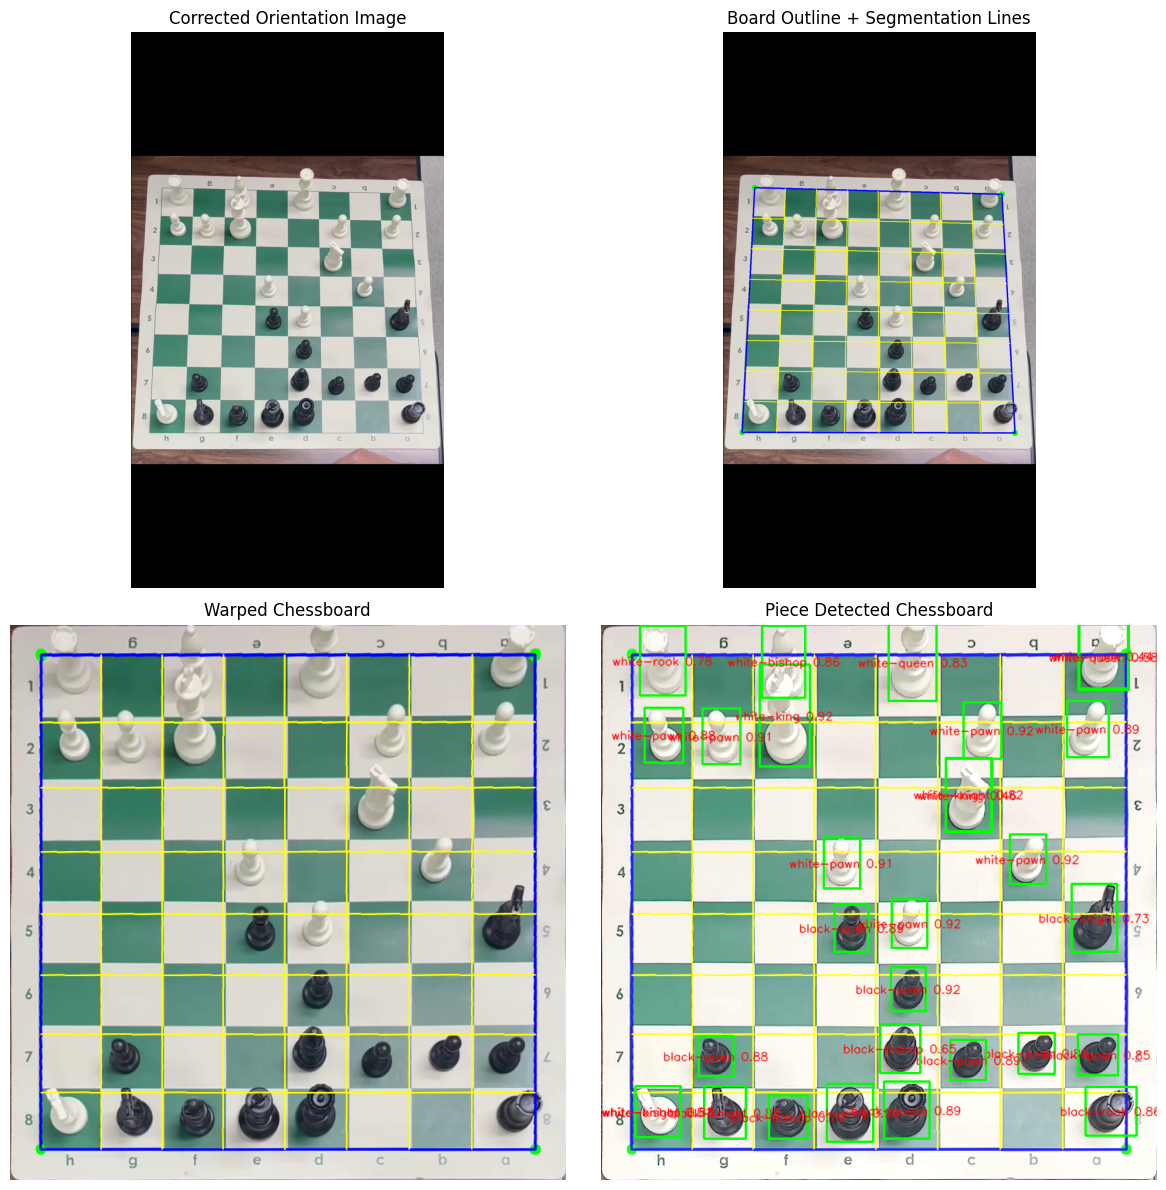

R | - | B | - | Q | - | - | R
P | P | K | - | - | P | - | P
- | - | - | - | - | K | - | -
- | - | - | P | - | - | P | -
- | - | - | p | P | - | - | n
- | - | - | - | p | - | - | -
- | p | - | - | b | p | p | p
N | n | b | k | q | - | - | r


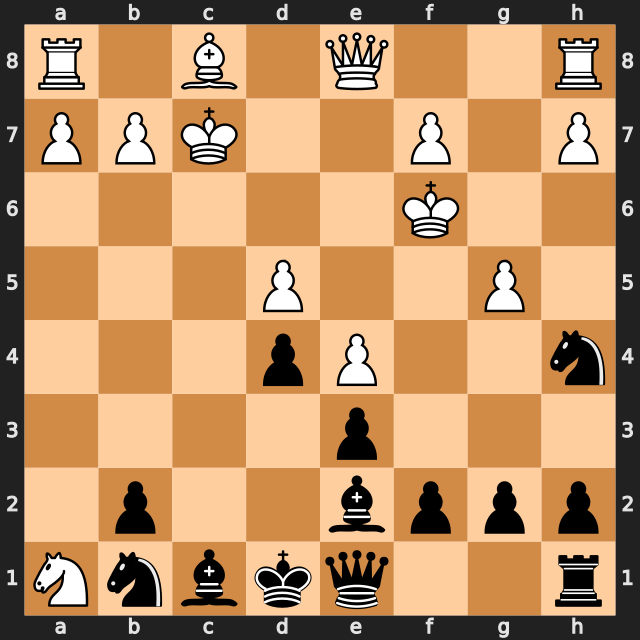

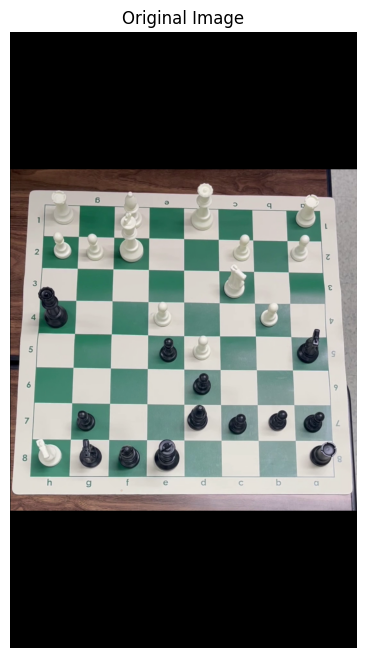


0: 640x384 4 chess-table-cornerss, 215.1ms
Speed: 4.6ms preprocess, 215.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 6 black-pawns, 1 black-queen, 2 black-rooks, 2 white-bishops, 1 white-king, 1 white-knight, 7 white-pawns, 2 white-queens, 2 white-rooks, 288.9ms
Speed: 6.0ms preprocess, 288.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


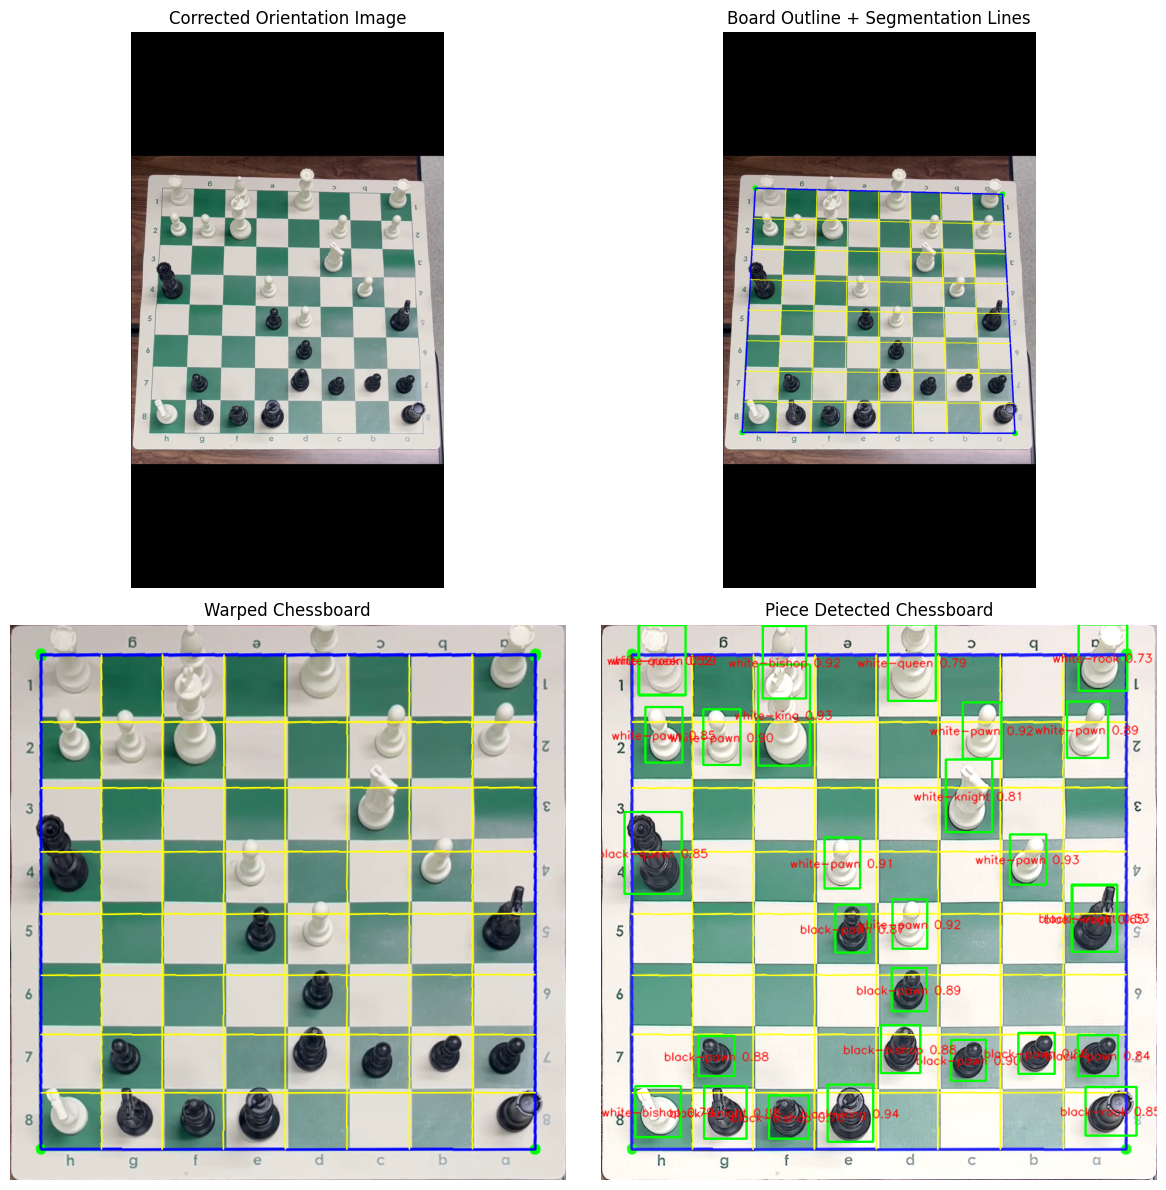

R | - | B | - | Q | - | - | R
P | P | K | - | - | P | - | P
- | - | - | - | - | N | - | -
q | - | - | P | - | - | P | -
- | - | - | p | P | - | - | n
- | - | - | - | p | - | - | -
- | p | - | - | b | p | p | p
B | n | b | k | - | - | - | r


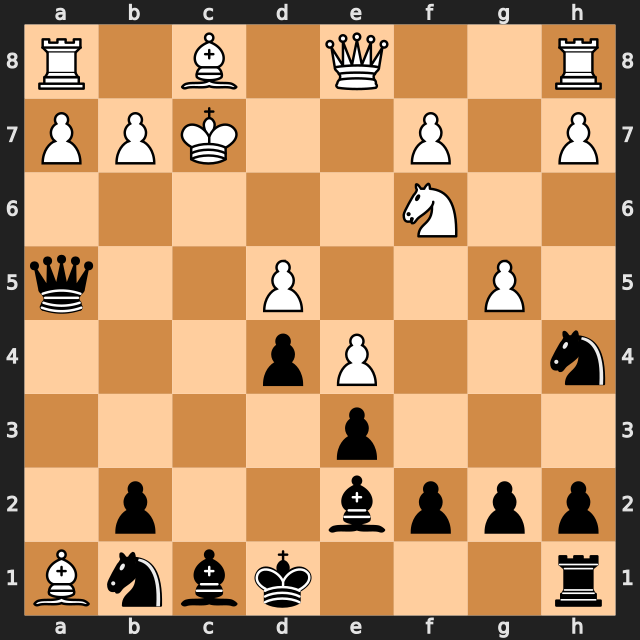

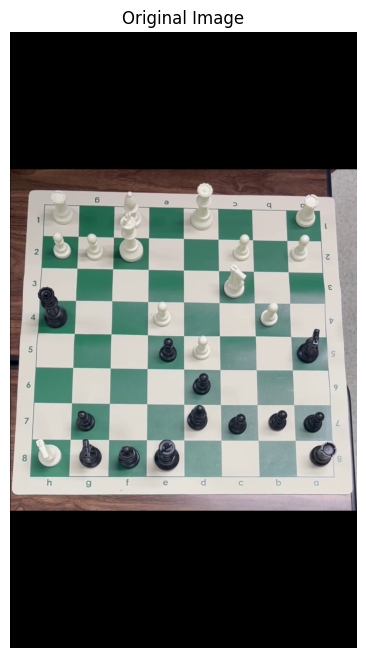


0: 640x384 4 chess-table-cornerss, 141.4ms
Speed: 4.4ms preprocess, 141.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 6 black-pawns, 1 black-queen, 2 black-rooks, 2 white-bishops, 3 white-kings, 1 white-knight, 7 white-pawns, 3 white-queens, 1 white-rook, 213.5ms
Speed: 6.1ms preprocess, 213.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


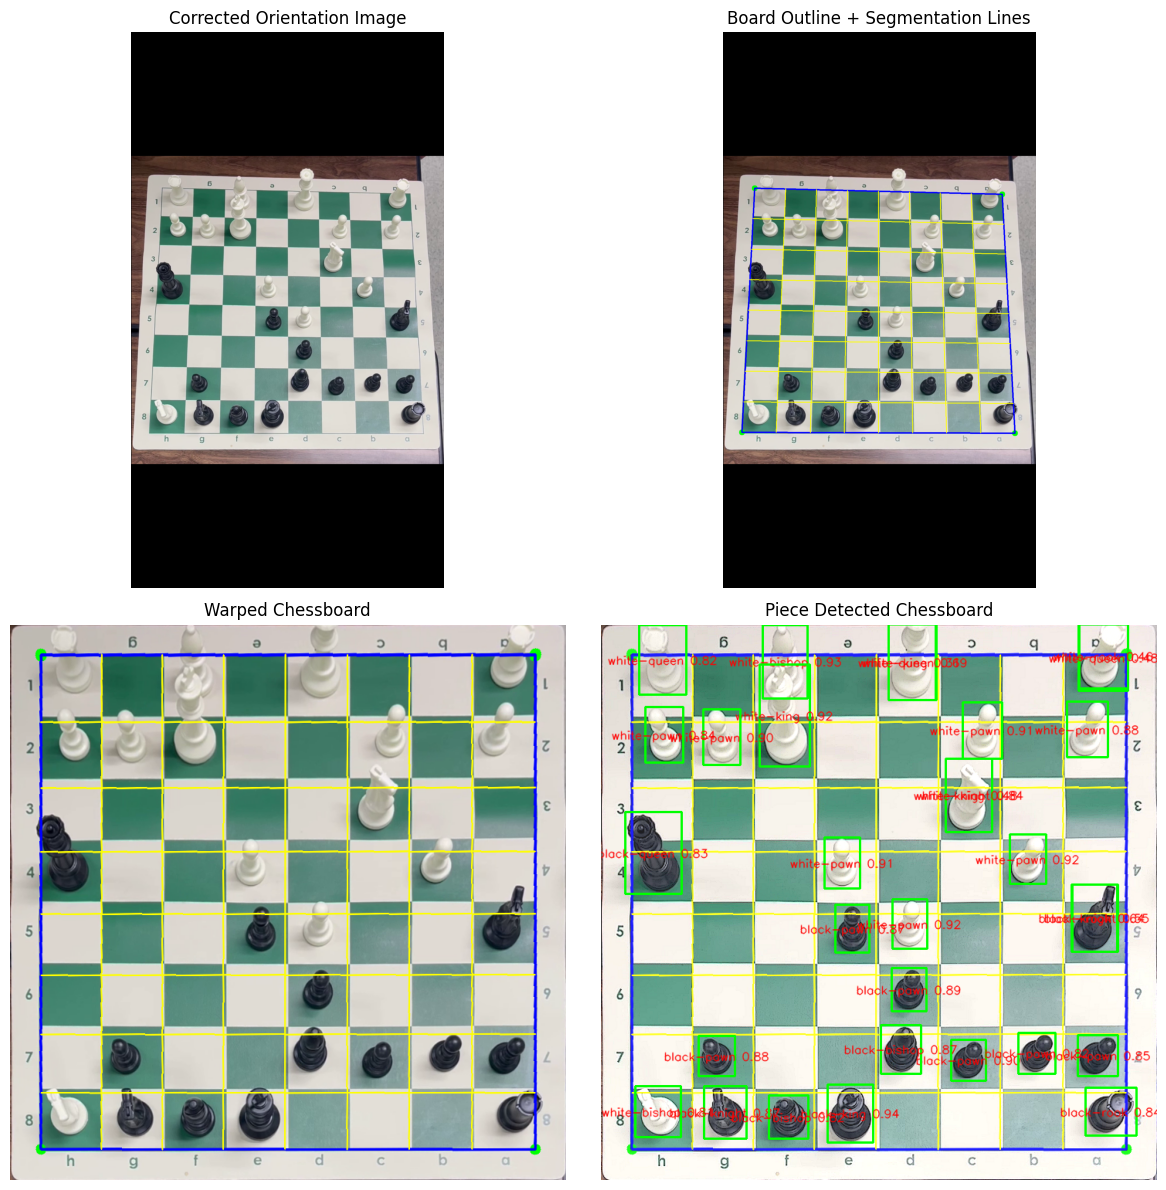

Q | - | B | - | K | - | - | R
P | P | K | - | - | P | - | P
- | - | - | - | - | K | - | -
q | - | - | P | - | - | P | -
- | - | - | p | P | - | - | n
- | - | - | - | p | - | - | -
- | p | - | - | b | p | p | p
B | n | b | k | - | - | - | r


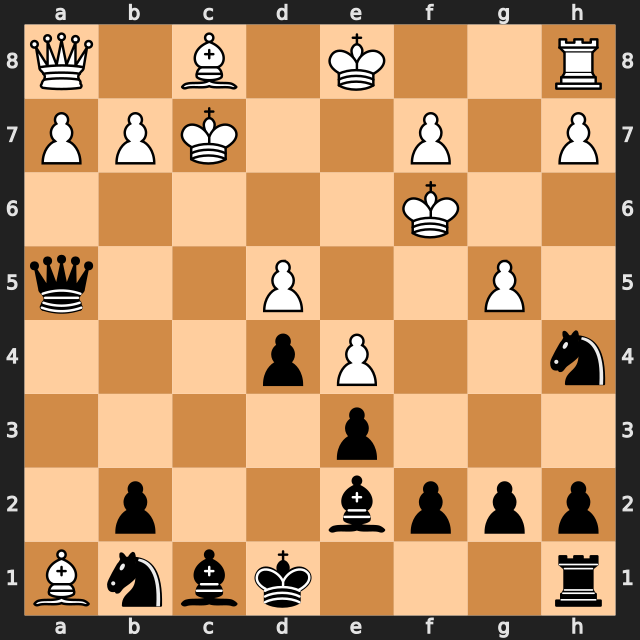

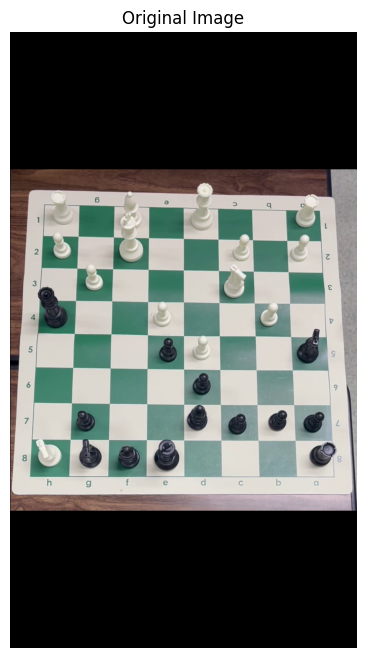


0: 640x384 4 chess-table-cornerss, 170.0ms
Speed: 4.7ms preprocess, 170.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 6 black-pawns, 1 black-queen, 2 black-rooks, 2 white-bishops, 3 white-kings, 2 white-knights, 7 white-pawns, 2 white-queens, 2 white-rooks, 283.2ms
Speed: 5.9ms preprocess, 283.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


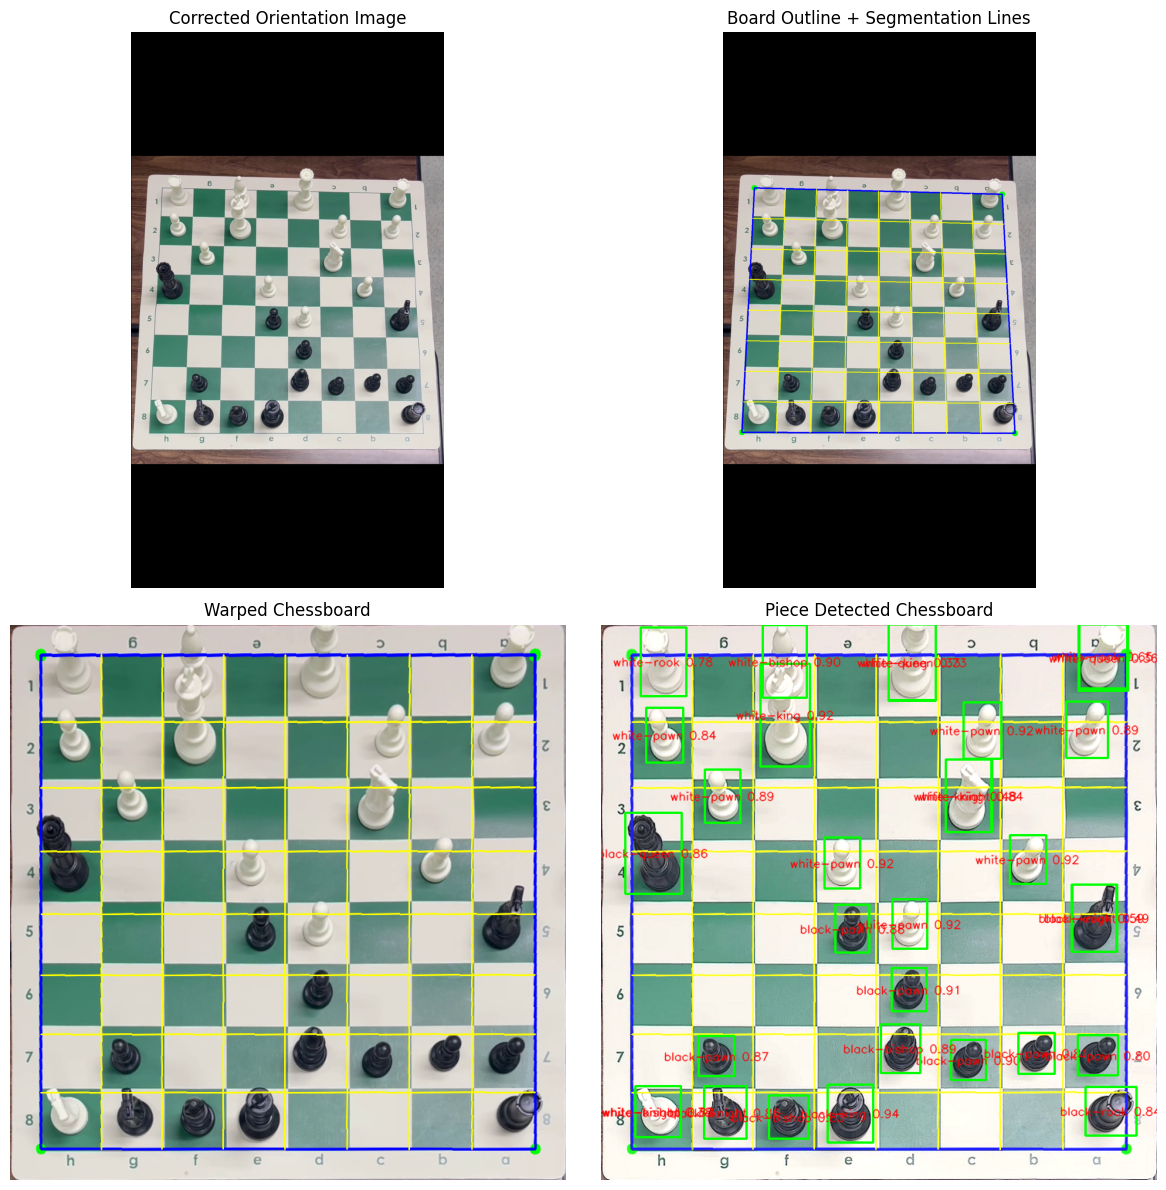

R | - | B | - | K | - | - | Q
P | - | K | - | - | P | - | P
- | P | - | - | - | K | - | -
q | - | - | P | - | - | P | -
- | - | - | p | P | - | - | n
- | - | - | - | p | - | - | -
- | p | - | - | b | p | p | p
N | n | b | k | - | - | - | r


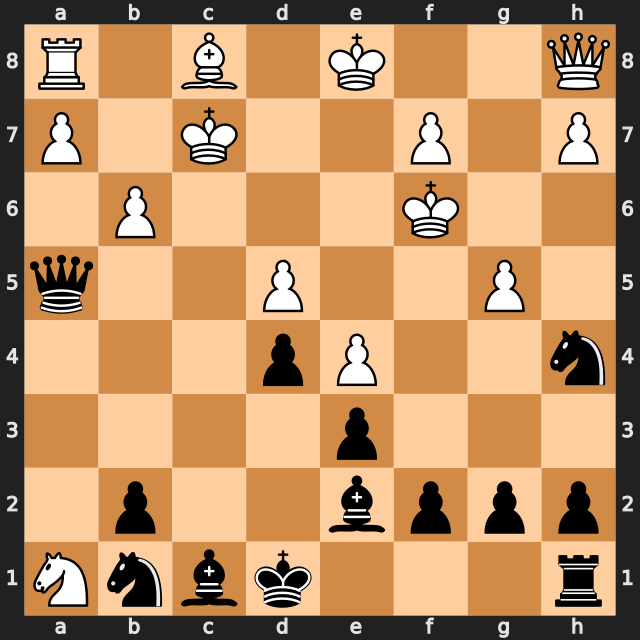

[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

*
your result:  [Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

*
solution   :  1. Qh4+ 2. g3
The edit distance between your results and solution is 0.05319148936170215.
-----------------------
Total score : 0.026595744680851074
-----------------------


In [111]:
# Read videos
import editdistance

f = open('chess_solution_final_seen.csv','r')
lines = f.readlines()
score = 0
n = 2

video_name, moves_sol, p,link = lines[n].strip().split(',')
print(video_name)
moves = chess_move(video_name)
s = 1 - editdistance.eval(moves,moves_sol)  / max(len(moves),len(moves_sol))
score += s
print(f"your result: ",moves)
print(f"solution   : ",moves_sol )
print(f"The edit distance between your results and solution is {s}.")
f.close()

if n != 0:
  print("-----------------------")
  print("Total score :",score/n)
  print("-----------------------")

# Test w/ Image

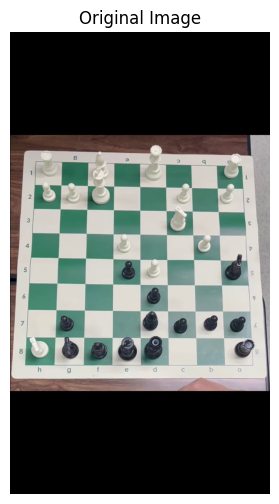


0: 640x384 4 chess-table-cornerss, 146.1ms
Speed: 6.2ms preprocess, 146.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)
Detected corners: (4, 2)
✅ 4 corners detected


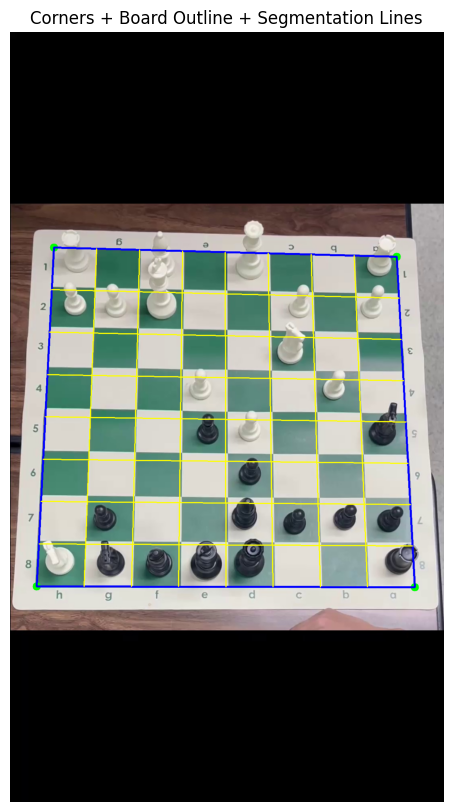

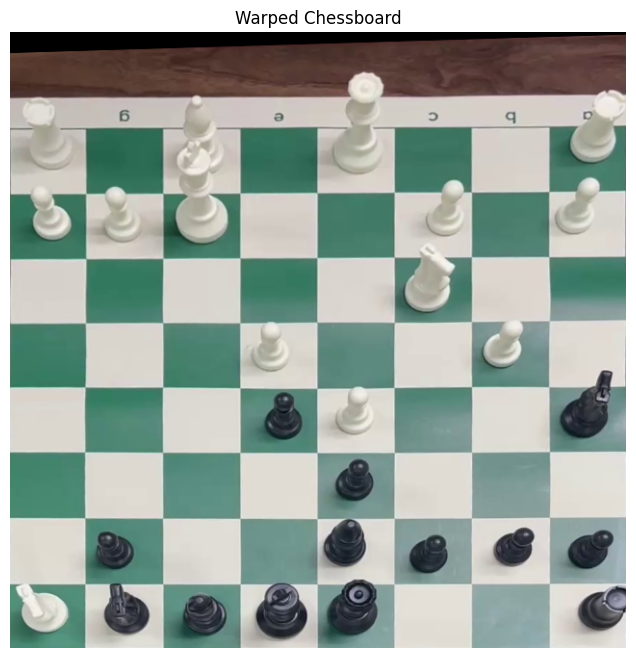

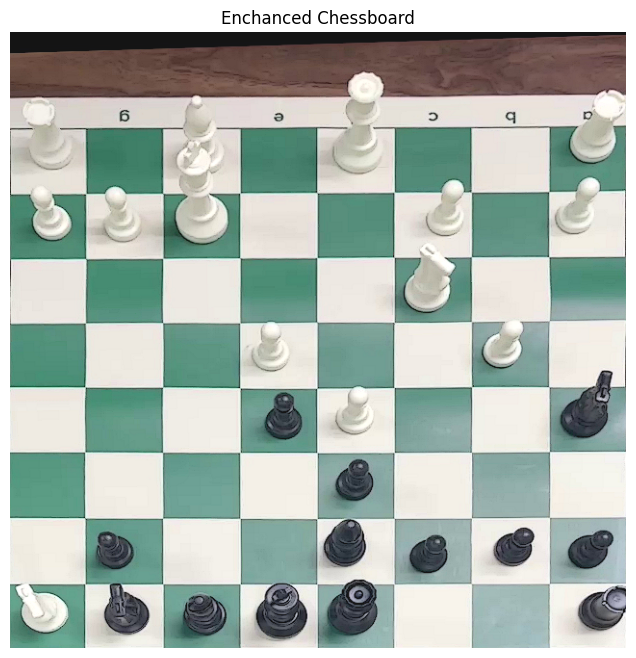


0: 640x640 6 black-bishops, 1 black-king, 2 black-knights, 6 black-pawns, 1 black-queen, 1 black-rook, 1 white-bishop, 1 white-king, 3 white-knights, 7 white-pawns, 3 white-queens, 3 white-rooks, 197.1ms
Speed: 4.6ms preprocess, 197.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


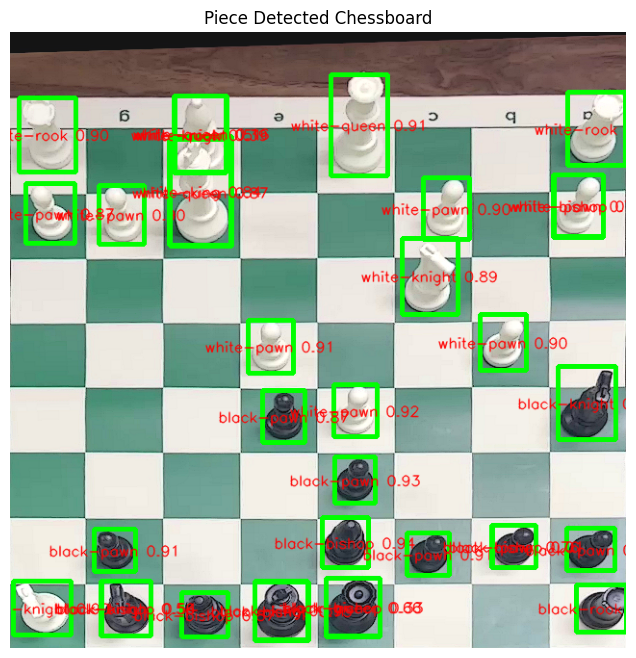

white-rook      | None            | white-queen     | None            | white-queen     | None            | None            | white-rook     
white-pawn      | white-pawn      | white-king      | None            | None            | white-pawn      | None            | white-bishop   
None            | None            | None            | None            | None            | white-knight    | None            | None           
None            | None            | None            | white-pawn      | None            | None            | white-pawn      | None           
None            | None            | None            | black-pawn      | white-pawn      | None            | None            | black-knight   
None            | None            | None            | None            | black-pawn      | None            | None            | None           
None            | black-pawn      | None            | None            | black-bishop    | black-pawn      | black-bishop    | black-pawn     
white-

In [34]:
reader = easyocr.Reader(['en'], gpu=True)

# Load and pre-process
img = cv2.imread("/content/dataset1_nolabel/frame0.jpg")
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.show()

# Orientation correction using chess board labels
#img_corrected = find_correct_orientation_image(img, reader)
#labels, img_with_labels = detect_board_labels(img_corrected, reader)

#plt.figure(figsize=(10, 6))
#plt.imshow(cv2.cvtColor(img_with_labels, cv2.COLOR_BGR2RGB))
#plt.title("Corrected Orientation + Detected Labels")
#plt.axis("off")
#plt.show()

#print("Final labels after orientation correction:", labels)

img_corrected = img.copy()

# Load trained model
model = YOLO('best.pt')

# Last good corners backup
last_good_corners = None

# Run YOLO prediction
results = model.predict(source=img_corrected, imgsz=640, line_width=1, conf=0.25, save_txt=False, save=False)

# Extract detected corners
all_corners = []
for r in results:
    for box in r.boxes.xyxy:  # boxes: (x1, y1, x2, y2)
        x1, y1, x2, y2 = box.tolist()
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        all_corners.append([cx, cy])
all_corners = np.array(all_corners, dtype=np.float32)

print("Detected corners:", all_corners.shape)

# Smart fallback
if len(all_corners) == 4:
    print("✅ 4 corners detected")
    ordered_corners = order_points(all_corners)
    last_good_corners = ordered_corners
elif len(all_corners) == 3:
    print("⚠️ Only 3 corners detected, predicting missing one...")
    predicted_corners = predict_missing_corner(all_corners)
    ordered_corners = order_points(predicted_corners)
    last_good_corners = ordered_corners
elif last_good_corners is not None:
    print("⚠️ Using last good corners!")
    ordered_corners = last_good_corners
else:
    raise Exception("❌ Cannot detect enough corners and no backup available.")

img_corners = img_corrected.copy()

# Draw detected corner points
for (x, y) in ordered_corners:
    cv2.circle(img_corners, (int(x), int(y)), 10, (0, 255, 0), -1)  # Green dots

# Draw big contour (the board rectangle)
pts = ordered_corners.reshape((-1, 1, 2)).astype(np.int32)
cv2.polylines(img_corners, [pts], isClosed=True, color=(255, 0, 0), thickness=3)  # Blue rectangle

# Draw internal grid lines (8x8 squares)
# interpolate points between the corners
for i in range(1, 8):
    # Horizontal lines (left to right between top and bottom edges)
    pt1 = ordered_corners[0] + i / 8 * (ordered_corners[1] - ordered_corners[0])
    pt2 = ordered_corners[3] + i / 8 * (ordered_corners[2] - ordered_corners[3])
    cv2.line(img_corners, tuple(pt1.astype(int)), tuple(pt2.astype(int)), (0, 255, 255), 2)

    # Vertical lines (top to bottom between left and right edges)
    pt1 = ordered_corners[0] + i / 8 * (ordered_corners[3] - ordered_corners[0])
    pt2 = ordered_corners[1] + i / 8 * (ordered_corners[2] - ordered_corners[1])
    cv2.line(img_corners, tuple(pt1.astype(int)), tuple(pt2.astype(int)), (0, 255, 255), 2)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
plt.title("Corners + Board Outline + Segmentation Lines")
plt.axis('off')
plt.show()

# Warp the chessboard
warped_board = warp_chessboard(img_corrected, ordered_corners, 640, 100)

# Show warped board
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(warped_board, cv2.COLOR_BGR2RGB))
plt.title('Warped Chessboard')
plt.axis('off')
plt.show()

# Enhance Image
lap_filter = np.array([[0,1,0],[1,-4,1],[0,1,0]],np.int16)
dst_im = cv2.filter2D(warped_board,-1,lap_filter)
enhanced_img = cv2.subtract(warped_board, np.clip(dst_im, 0, 255).astype(np.uint8))
brightness_increase = 20
enhanced_img = cv2.add(enhanced_img, brightness_increase)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
plt.title('Enchanced Chessboard')
plt.axis('off')
plt.show()

# Set up the board grid
w, h, _ = warped_board.shape

x_min = 0
y_min = 100
x_max = w
y_max = h

square_width = (x_max - x_min) / 8
square_height = (y_max - y_min) / 8

# Initialize 8x8 array empty board
board = [[None for _ in range(8)] for _ in range(8)]

# Detect Piece
piece_model = YOLO('/content/chesspieces_best.pt')
results = piece_model.predict(enhanced_img, imgsz=640, conf=0.01)

for box in results[0].boxes:
  x1, y1, x2, y2 = map(int, box.xyxy[0])
  conf = float(box.conf[0])
  cls_id = int(box.cls[0])
  label = results[0].names[cls_id]

  label_text = f"{label} {conf:.2f}"

  # Draw bounding box
  cv2.rectangle(enhanced_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

  # Calculate the center point of the box
  center_x = int((x1 + x2) / 2)
  center_y = int((y1 + y2) / 2)

  # Get anchor point of the piece
  anchor_x = (x1 + x2) / 2
  anchor_y = y2

  # Find which square the center point falls into
  col = int((anchor_x - x_min) / square_width)
  row = int((anchor_y - y_min) / square_height)

  # Clamp to [0, 7]
  col = min(max(col, 0), 7)
  row = min(max(row, 0), 7)

  # Place the piece label on the board
  board[row][col] = label

  # Draw label text inside the box, centered
  font_scale = 0.5   # Smaller text
  thickness = 1
  text_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
  text_w, text_h = text_size

  # Adjust so that text is centered
  text_x = center_x - text_w // 2
  text_y = center_y + text_h // 2

  cv2.putText(enhanced_img, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), thickness, cv2.LINE_AA)

# Show result board
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
plt.title('Piece Detected Chessboard')
plt.axis('off')
plt.show()

for row in board:
    print(" | ".join(f"{str(item):<{15}}" for i, item in enumerate(row)))